In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import pandas as pd
%matplotlib inline


In [2]:
#helper functions

def box_corner_to_center(boxes):
    """Convert from (upper_left, bottom_right) to (center, width, height)"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper_left, bottom_right)"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (top-left x, top-left y, bottom-right x,
    # bottom-right y) format to matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0],
                      rect.xy[1],
                      labels[i],
                      va='center',
                      ha='center',
                      fontsize=9,
                      color=text_color,
                      bbox=dict(facecolor=color, lw=0))
            
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
    
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## Anchor box

Object detection algorithms usually sample a large number of regions in the input image, determine whether these regions contain objects of interest, and adjust the edges of the regions so as to predict the ground-truth bounding box of the target more accurately. Different models may use different region sampling methods. Here, we introduce one such method: it generates multiple bounding boxes with different sizes and aspect ratios while centering on each pixel. These bounding boxes are called anchor boxes. We will practice object detection based on anchor boxes in the following sections.

### Generating Multiple anchor boxes

Assume that the input image has a height of  $h$  and width of  $w$ . We generate anchor boxes with different shapes centered on each pixel of the image. Assume the size is  $s∈(0,1]$ , the aspect ratio is  $r>0$ , and the width and height of the anchor box are  $ws\sqrt r$  and  $hs/\sqrt r$ , respectively. When the center position is given, an anchor box with known width and height is determined.

Below we set a set of sizes  $s1,…,sn$  and a set of aspect ratios  $r1,…,rm$ . If we use a combination of all sizes and aspect ratios with each pixel as the center, the input image will have a total of  $whnm$  anchor boxes. Although these anchor boxes may cover all ground-truth bounding boxes, the computational complexity is often excessive. Therefore, we are usually only interested in a combination containing  $s1$  or  $r1$  sizes and aspect ratios, that is:


$(s1,r1),(s1,r2),…,(s1,rm),(s2,r1),(s3,r1),…,(sn,r1).$
 
That is, the number of anchor boxes centered on the same pixel is  $n+m−1$ . For the entire input image, we will generate a total of  $wh(n+m−1)$  anchor boxes.


In [3]:
def multibox_prior(data, sizes, ratios):
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    
    # Offsets are required to move the anchor to center of a pixel
    # Since pixel (height=1, width=1), we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate boxes_per_pixel number of heights and widths which are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    # cat (various sizes, first ratio) and (first size, various ratios)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # Each center point will have boxes_per_pixel number of anchor boxes, so
    # generate grid of all anchor box centers with boxes_per_pixel repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)

    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [4]:
##Read image
img = plt.imread("catdog.jpg")

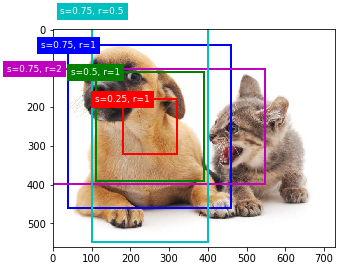

In [5]:
h, w = img.shape[0:2]

X = torch.rand(size=(1, 3, h, w)) # Construct input data. Random image of size (1,3,h,w) where h,w is the height and width of catdog image
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
#Y should have a shape of (1,w*h*(3+3-1),4)
#We reshape Y so that it has a shape of  (image height, image width, number of anchor boxes centered on the same pixel, 4)
boxes = Y.reshape(h, w, 5, 4)

bbox_scale = np.array((w, h, w, h))
fig = plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

## Intersection over Union

We just mentioned that the anchor box covers the dog in the image well. If the ground-truth bounding box of the target is known, how can "well" here be quantified? An intuitive method is to measure the similarity between anchor boxes and the ground-truth bounding box. We know that the Jaccard index can measure the similarity between two sets. Given sets $\mathcal{A}$ and $\mathcal{B}$, their Jaccard index is the size of their intersection divided by the size of their union:

$$J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$$


In fact, we can consider the pixel area of a bounding box as a collection of pixels. In this way, we can measure the similarity of the two bounding boxes by the Jaccard index of their pixel sets. When we measure the similarity of two bounding boxes, we usually refer the Jaccard index as intersection over union (IoU), which is the ratio of the intersecting area to the union area of the two bounding boxes, as shown in the figure below. The value range of IoU is between 0 and 1: 0 means that there are no overlapping pixels between the two bounding boxes, while 1 indicates that the two bounding boxes are equal.

![IoU is the ratio of the intersecting area to the union area of two bounding boxes.  ](http://d2l.ai/_images/iou.svg)


For the remainder of this section, we will use IoU to measure the similarity between anchor boxes and ground-truth bounding boxes, and between different anchor boxes.


## Q1 Find bbox iou 

**fill the function below assume that input and output are torch tensors. Function finds IOU between two sets for boxes having different shapes. Function should return $N X M$ matrix containing IOU values. Avoid using for loops.**

In [6]:
def box_iou(boxes1, boxes2):
    """Compute IOU between two sets of boxes of shape (N,4) and (M,4)."""
    # Compute box areas
    boxes1_area = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1]) # [N,1]
    boxes2_area = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1]) # [M,1]
    
    lt = torch.max(boxes1[:,None,:2], boxes2[:,:2])  # [N,M,2]
    rb = torch.min(boxes1[:,None,2:], boxes2[:,2:])  # [N,M,2]

    wh = (rb-lt).clamp(min=0)      # [N,M,2]
    inter = wh[:,:,0] * wh[:,:,1]  # [N,M]
    iou = inter / (boxes1_area[:,None] + boxes2_area - inter)
    return iou

## Labeling Training Set Anchor Boxes


In the training set, we consider each anchor box as a training example. In order to train the object detection model, we need to mark two types of labels for each anchor box: first, the category of the target contained in the anchor box (category) and, second, the offset of the ground-truth bounding box relative to the anchor box (offset). In object detection, we first generate multiple anchor boxes, predict the categories and offsets for each anchor box, adjust the anchor box position according to the predicted offset to obtain the bounding boxes to be used for prediction, and finally filter out the prediction bounding boxes that need to be output.


We know that, in the object detection training set, each image is labelled with the location of the ground-truth bounding box and the category of the target contained. After the anchor boxes are generated, we primarily label anchor boxes based on the location and category information of the ground-truth bounding boxes similar to the anchor boxes. So how do we assign ground-truth bounding boxes to anchor boxes similar to them?


Assume that the anchor boxes in the image are $A_1, A_2, \ldots, A_{n_a}$ and the ground-truth bounding boxes are $B_1, B_2, \ldots, B_{n_b}$ and $n_a \geq n_b$. Define matrix $\mathbf{X} \in \mathbb{R}^{n_a \times n_b}$, where element $x_{ij}$ in the $i^\mathrm{th}$ row and $j^\mathrm{th}$ column is the IoU of the anchor box $A_i$ to the ground-truth bounding box $B_j$.
First, we find the largest element in the matrix $\mathbf{X}$ and record the row index and column index of the element as $i_1,j_1$. We assign the ground-truth bounding box $B_{j_1}$ to the anchor box $A_{i_1}$. Obviously, anchor box $A_{i_1}$ and ground-truth bounding box $B_{j_1}$ have the highest similarity among all the "anchor box--ground-truth bounding box" pairings. Next, discard all elements in the $i_1$th row and the $j_1$th column in the matrix $\mathbf{X}$. Find the largest remaining element in the matrix $\mathbf{X}$ and record the row index and column index of the element as $i_2,j_2$. We assign ground-truth bounding box $B_{j_2}$ to anchor box $A_{i_2}$ and then discard all elements in the $i_2$th row and the $j_2$th column in the matrix $\mathbf{X}$. At this point, elements in two rows and two columns in the matrix $\mathbf{X}$ have been discarded.


We proceed until all elements in the $n_b$ column in the matrix $\mathbf{X}$ are discarded. At this time, we have assigned a ground-truth bounding box to each of the $n_b$ anchor boxes.
Next, we only traverse the remaining $n_a - n_b$ anchor boxes. Given anchor box $A_i$, find the bounding box $B_j$ with the largest IoU with $A_i$ according to the $i^\mathrm{th}$ row of the matrix $\mathbf{X}$, and only assign ground-truth bounding box $B_j$ to anchor box $A_i$ when the IoU is greater than the predetermined threshold.


As shown in figure below (left), assuming that the maximum value in the matrix $\mathbf{X}$ is $x_{23}$, we will assign ground-truth bounding box $B_3$ to anchor box $A_2$. Then, we discard all the elements in row 2 and column 3 of the matrix, find the largest element $x_{71}$ of the remaining shaded area, and assign ground-truth bounding box $B_1$ to anchor box $A_7$. Then, as shown in :numref:`fig_anchor_label`  (middle), discard all the elements in row 7 and column 1 of the matrix, find the largest element $x_{54}$ of the remaining shaded area, and assign ground-truth bounding box $B_4$ to anchor box $A_5$.  Finally, as shown in :numref:`fig_anchor_label` (right), discard all the elements in row 5 and column 4 of the matrix, find the largest element $x_{92}$ of the remaining shaded area, and assign ground-truth bounding box $B_2$ to anchor box $A_9$.  After that, we only need to traverse the remaining anchor boxes of $A_1, A_3, A_4, A_6, A_8$ and determine whether to assign ground-truth bounding boxes to the remaining anchor boxes according to the threshold.

![Assign ground-truth bounding boxes to anchor boxes. ](anchor-label.svg)

In [7]:
def match_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign ground-truth bounding boxes to anchor boxes similar to them."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element `x_ij` in the `i^th` row and `j^th` column is the IoU
    # of the anchor box `anc_i` to the ground-truth bounding box `box_j`
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold assigned ground truth bbox for each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Assign ground truth bounding box according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    # Find the largest iou for each bbox
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

Now we can label the categories and offsets of the anchor boxes. If an anchor box $A$ is assigned ground-truth bounding box $B$, the category of the anchor box $A$ is set to the category of $B$. And the offset of the anchor box $A$ is set according to the relative position of the central coordinates of $B$ and $A$ and the relative sizes of the two boxes. Because the positions and sizes of various boxes in the dataset may vary, these relative positions and relative sizes usually require some special transformations to make the offset distribution more uniform and easier to fit. Assume the center coordinates of anchor box $A$ and its assigned ground-truth bounding box $B$ are $(x_a, y_a), (x_b, y_b)$, the widths of $A$ and $B$ are $w_a, w_b$, and their heights are $h_a, h_b$, respectively. In this case, a common technique is to label the offset of $A$ as

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$

The default values of the constant are $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1, and \sigma_w=\sigma_h=0.2$.
This transformation is implemented in the `offset_boxes` function.
If an anchor box is not assigned a ground-truth bounding box, we only need to set the category of the anchor box to background. Anchor boxes whose category is background are often referred to as negative anchor boxes, and the rest are referred to as positive anchor boxes.

Below we demonstrate a detailed example. We define ground-truth bounding boxes for the cat and dog in the read image, where the first element is category (0 for dog, 1 for cat) and the remaining four elements are the $x, y$ axis coordinates at top-left corner and $x, y$ axis coordinates at lower-right corner (the value range is between 0 and 1). Here, we construct five anchor boxes to be labeled by the coordinates of the upper-left corner and the lower-right corner, which are recorded as $A_0, \ldots, A_4$, respectively (the index in the program starts from 0). First, draw the positions of these anchor boxes and the ground-truth bounding boxes in the image.

In [8]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

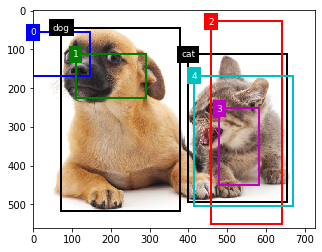

In [9]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

We can label categories and offsets for anchor boxes by using the `multibox_target` function. This function sets the background category to 0 and increments the integer index of the target category from zero by 1 (1 for dog and 2 for cat).

We add example dimensions to the anchor boxes and ground-truth bounding boxes and construct random predicted results with a shape of (batch size, number of categories including background, number of anchor boxes) by using the `unsqueeze` function.

In [10]:
def multibox_target(anchors, labels):
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = match_anchor_to_bbox(label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        # Initialize class_labels and assigned bbox coordinates with zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # Assign class labels to the anchor boxes using matched gt bbox labels
        # If no gt bbox is assigned to an anchor box, then let the
        # class_labels and assigned_bb remain zero, i.e the background class
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # offset transformations
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

labels[2]

tensor([[0, 1, 2, 0, 2]])

We analyze these labelled categories based on positions of anchor boxes and ground-truth bounding boxes in the image. First, in all "anchor box--ground-truth bounding box" pairs, the IoU of anchor box $A_4$ to the ground-truth bounding box of the cat is the largest, so the category of anchor box $A_4$ is labeled as cat. Without considering anchor box $A_4$ or the ground-truth bounding box of the cat, in the remaining "anchor box--ground-truth bounding box" pairs, the pair with the largest IoU is anchor box $A_1$ and the ground-truth bounding box of the dog, so the category of anchor box $A_1$ is labeled as dog. Next, traverse the remaining three unlabeled anchor boxes. The category of the ground-truth bounding box with the largest IoU with anchor box $A_0$ is dog, but the IoU is smaller than the threshold (the default is 0.5), so the category is labeled as background; the category of the ground-truth bounding box with the largest IoU with anchor box $A_2$ is cat and the IoU is greater than the threshold, so the category is labeled as cat; the category of the ground-truth bounding box with the largest IoU with anchor box $A_3$ is cat, but the IoU is smaller than the threshold, so the category is labeled as background.


The second item of the return value is a mask variable, with the shape of (batch size, four times the number of anchor boxes). The elements in the mask variable correspond one-to-one with the four offset values of each anchor box.
Because we do not care about background detection, offsets of the negative class should not affect the target function. By multiplying by element, the 0 in the mask variable can filter out negative class offsets before calculating target function.

## Bounding Boxes for Prediction

During model prediction phase, we first generate multiple anchor boxes for the image and then predict categories and offsets for these anchor boxes one by one. Then, we obtain prediction bounding boxes based on anchor boxes and their predicted offsets.

Below we implement function `offset_inverse` which takes in anchors and
offset predictions as inputs and applies inverse offset transformations to
return the predicted bounding box coordinates.

When there are many anchor boxes, many similar prediction bounding boxes may be output for the same target. To simplify the results, we can remove similar prediction bounding boxes. A commonly used method is called non-maximum suppression (NMS).

Let us take a look at how NMS works. For a prediction bounding box  B , the model calculates the predicted probability for each category. Assume the largest predicted probability is  p , the category corresponding to this probability is the predicted category of  B . We also refer to  p  as the confidence level of prediction bounding box  B . On the same image, we sort the prediction bounding boxes with predicted categories other than background by confidence level from high to low, and obtain the list  L . Select the prediction bounding box  B1  with highest confidence level from  L  as a baseline and remove all non-benchmark prediction bounding boxes with an IoU with  B1  greater than a certain threshold from  L . The threshold here is a preset hyperparameter. At this point,  L  retains the prediction bounding box with the highest confidence level and removes other prediction bounding boxes similar to it. Next, select the prediction bounding box  B2  with the second highest confidence level from  L  as a baseline, and remove all non-benchmark prediction bounding boxes with an IoU with  B2  greater than a certain threshold from  L . Repeat this process until all prediction bounding boxes in  L  have been used as a baseline. At this time, the IoU of any pair of prediction bounding boxes in  L  is less than the threshold. Finally, output all prediction bounding boxes in the list  L .


In [11]:
def offset_inverse(anchors, offset_preds):
    c_anc = box_corner_to_center(anchors)
    c_pred_bb_xy = (offset_preds[:, :2] * c_anc[:, 2:] / 10) + c_anc[:, :2]
    c_pred_bb_wh = torch.exp(offset_preds[:, 2:] / 5) * c_anc[:, 2:]
    c_pred_bb = torch.cat((c_pred_bb_xy, c_pred_bb_wh), axis=1)
    predicted_bb = box_center_to_corner(c_pred_bb)
    return predicted_bb

In [12]:
def nms(boxes, scores, iou_threshold):
    # sorting scores by the descending order and return their indices
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # boxes indices that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.00999999978):
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, 0.5)
        # Find all non_keep indices and set the class_id to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # threshold to be a positive prediction
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

Next, we will look at a detailed example. First, construct four anchor boxes. For the sake of simplicity, we assume that predicted offsets are all 0. This means that the prediction bounding boxes are anchor boxes. Finally, we construct a predicted probability for each category

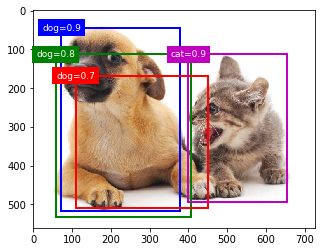

In [13]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([
    [0] * 4,  # Predicted probability for background
    [0.9, 0.8, 0.7, 0.1],  # Predicted probability for dog
    [0.1, 0.2, 0.3, 0.9]
])  # Predicted probability for cat

fig = plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [14]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100]]])

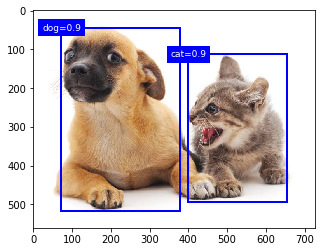

In [15]:
fig = plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

In practice, we can remove prediction bounding boxes with lower confidence levels before performing NMS, thereby reducing the amount of computation for NMS. We can also filter the output of NMS, for example, by only retaining results with higher confidence levels as the final output.

## Multiscale Object Detection

We generated multiple anchor boxes centered on each pixel of the input image.  These anchor boxes are used to sample different regions of the input image. However, if anchor boxes are generated centered on each pixel of the image, soon there will be too many anchor boxes for us to compute. For example, we assume that the input image has a height and a width of 561 and 728 pixels respectively. If five different shapes of anchor boxes are generated centered on each pixel, over two million anchor boxes ($561 \times 728 \times 5$) need to be predicted and labeled on the image.

It is not difficult to reduce the number of anchor boxes.  An easy way is to apply uniform sampling on a small portion of pixels from the input image and generate anchor boxes centered on the sampled pixels. In addition, we can generate anchor boxes of varied numbers and sizes on multiple scales. Notice that smaller objects are more likely to be positioned on the image than larger ones.  Here, we will use a simple example: Objects with shapes of $1 \times 1$, $1 \times 2$, and $2 \times 2$ may have 4, 2, and 1 possible position(s) on an image with the shape $2 \times 2$. Therefore, when using smaller anchor boxes to detect smaller objects, we can sample more regions; when using larger anchor boxes to detect larger objects, we can sample fewer regions.

In Convolutional neural network, the 2D array output of the convolutional neural network (CNN) is called
a feature map.  We can determine the midpoints of anchor boxes uniformly sampled
on any image by defining the shape of the feature map.

The function `display_anchors` is defined below.  We are going to generate anchor boxes `anchors` centered on each unit (pixel) on the feature map `fmap`.  Since the coordinates of axes $x$ and $y$ in anchor boxes `anchors` have been divided by the width and height of the feature map `fmap`, values between 0 and 1 can be used to represent relative positions of anchor boxes in the feature map.  Since the midpoints of anchor boxes `anchors` overlap with all the units on feature map `fmap`, the relative spatial positions of the midpoints of the `anchors` on any image must have a uniform distribution.  Specifically, when the width and height of the feature map are set to `fmap_w` and `fmap_h` respectively, the function will conduct uniform sampling for `fmap_h` rows and `fmap_w` columns of pixels and use them as midpoints to generate anchor boxes with size `s` (we assume that the length of list `s` is 1) and different aspect ratios (`ratios`).

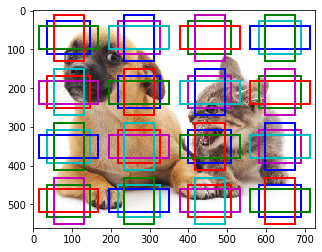

In [16]:
def display_anchors(fmap_w, fmap_h, s):
    # The values from the first two dimensions will not affect the output
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    show_bboxes(plt.imshow(img).axes,
                    anchors[0] * bbox_scale)
    
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

Finally, we are going to reduce the height and width of the feature map by half and increase the anchor box size to 0.8. Now the midpoint of the anchor box is the center of the image.

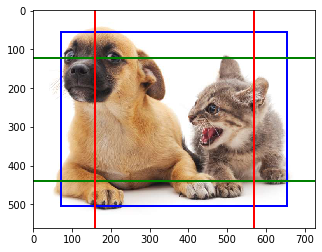

In [17]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

Since we have generated anchor boxes of different sizes on multiple scales, we will use them to detect objects of various sizes at different scales. Now we are going to introduce a method based on convolutional neural networks (CNNs).

At a certain scale, suppose we generate $h \times w$ sets of anchor boxes with different midpoints based on $c_i$ feature maps with the shape $h \times w$ and the number of anchor boxes in each set is $a$. For example, for the first scale of the experiment, we generate 16 sets of anchor boxes with different midpoints based on 10 (number of channels) feature maps with a shape of $4 \times 4$, and each set contains 3 anchor boxes.
Next, each anchor box is labeled with a category and offset based on the classification and position of the ground-truth bounding box. At the current scale, the object detection model needs to predict the category and offset of $h \times w$ sets of anchor boxes with different midpoints based on the input image.

We assume that the $c_i$ feature maps are the intermediate output of the CNN
based on the input image. Since each feature map has $h \times w$ different
spatial positions, the same position will have $c_i$ units.  According to the
definition of receptive field in the
:numref:`sec_conv_layer`, the $c_i$ units of the feature map at the same spatial position have
the same receptive field on the input image. Thus, they represent the
information of the input image in this same receptive field.  Therefore, we can
transform the $c_i$ units of the feature map at the same spatial position into
the categories and offsets of the $a$ anchor boxes generated using that position
as a midpoint.  It is not hard to see that, in essence, we use the information
of the input image in a certain receptive field to predict the category and
offset of the anchor boxes close to the field on the input image.

When the feature maps of different layers have receptive fields of different sizes on the input image, they are used to detect objects of different sizes. For example, we can design a network to have a wider receptive field for each unit in the feature map that is closer to the output layer, to detect objects with larger sizes in the input image.

We will implement a multiscale object detection model in the following section.

## Banana Dataset

There are no small datasets, like MNIST or Fashion-MNIST, in the object detection field. In order to quickly test models, we are going to assemble a small dataset. First, we generate 1000 banana images of different angles and sizes using free bananas from our office. Then, we collect a series of background images and place a banana image at a random position on each image.

## Q2

Write a Dataset for loading data. read comments for help. Dataset should return tensor image and tensor bounding box coordinates  

In [18]:
import torchvision
import os
class BananasDataset(torch.utils.data.Dataset):
    def __init__(self, label_path):
        """
        """
        # read label csv file. columns 1 is image name remaining columns are bounding box coordinates. 
        # It may happend that same images have multiple labels. in that case it should return one image tensor with a label tensor of approporate shape   
        csv_data = pd.read_csv(label_path).set_index('img_name')
        images, labels = [], []
        for img_name, label in csv_data.iterrows():
            images.append(torchvision.io.read_image(
                os.path.join(r"C:\Users\15106\Documents\skoruz\evaluations\Evaluation_3\banana-detection", 
                             'bananas_train' if "train" in label_path else
                             'bananas_val', 'images', f'{img_name}')))
            labels.append(list(label))
        self.images, self.labels = images, torch.tensor(labels).unsqueeze(1) / 256

    def __getitem__(self, idx):
        # for a single row in csv file (indexed by idx) read an image and return tensor image and tensor ground truth coordinates
        return (self.images[idx].float(), self.labels[idx])

    def __len__(self):
        #length of csv file with unique file paths
        #return self.data.shape[0]
        return len(self.images)

#@save
def load_data_bananas(batch_size,train_label_path,val_label_path):
    """Load the bananas dataset."""
    train_iter = torch.utils.data.DataLoader(BananasDataset(train_label_path),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(val_label_path),
                                           batch_size)
    return (train_iter, val_iter)

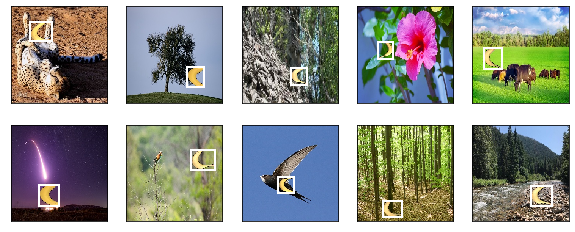

In [19]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size, 
                                  r"C:\Users\15106\Documents\skoruz\evaluations\Evaluation_3\banana-detection\bananas_train\label.csv",
                                 r"C:\Users\15106\Documents\skoruz\evaluations\Evaluation_3\banana-detection\bananas_val\label.csv")
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

# Single Shot Multibox Detection (SSD)

In the previous few sections, we have introduced bounding boxes, anchor boxes,
multiscale object detection, and datasets. Now, we will use this background
knowledge to construct an object detection model: single shot multibox detection
[SSD](https://arxiv.org/abs/1512.02325). This quick and easy model is already
widely used. Some of the design concepts and implementation details of this
model are also applicable to other object detection models like YOLO.


## Model

figure shows the design of an SSD model. The model's main components
are a base network block and several multiscale feature blocks connected in a
series. Here, the base network block is used to extract features of original
images, and it generally takes the form of a deep convolutional neural
network. The paper on SSDs chooses to place a truncated VGG before the
classification layer, but this is now
commonly replaced by ResNet. We can design the base network so that it outputs
larger heights and widths. In this way, more anchor boxes are generated based on
this feature map, allowing us to detect smaller objects. Next, each multiscale
feature block reduces the height and width of the feature map provided by the
previous layer (for example, it may reduce the sizes by half). The blocks then
use each element in the feature map to expand the receptive field on the input
image. In this way, the closer a multiscale feature block is to the top of
the smaller its output feature map, and the fewer the anchor
boxes that are generated based on the feature map. In addition, the closer a
feature block is to the top, the larger the receptive field of each element in
the feature map and the better suited it is to detect larger objects. As the SSD
generates different numbers of anchor boxes of different sizes based on the base
network block and each multiscale feature block and then predicts the categories
and offsets (i.e., predicted bounding boxes) of the anchor boxes in order to
detect objects of different sizes, SSD is a multiscale object detection model.

![The SSD is composed of a base network block and several multiscale feature blocks connected in a series. ](http://d2l.ai/_images/ssd.svg)



Next, we will describe the implementation of the modules in figure. First, we need to discuss the implementation of category prediction and bounding box prediction.

### Category Prediction Layer

Set the number of object categories to $q$. In this case, the number of anchor
box categories is $q+1$, with 0 indicating an anchor box that only contains
background. For a certain scale, set the height and width of the feature map to
$h$ and $w$, respectively. If we use each element as the center to generate $a$
anchor boxes, we need to classify a total of $hwa$ anchor boxes. If we use a
fully connected layer (FCN) for the output, this will likely result in an
excessive number of model parameters. SSD uses the
same method to reduce the model complexity.

Specifically, the category prediction layer uses a convolutional layer that
maintains the input height and width. Thus, the output and input have a
one-to-one correspondence to the spatial coordinates along the width and height
of the feature map. Assuming that the output and input have the same spatial
coordinates $(x, y)$, the channel for the coordinates $(x, y)$ on the output
feature map contains the category predictions for all anchor boxes generated
using the input feature map coordinates $(x, y)$ as the center. Therefore, there
are $a(q+1)$ output channels, with the output channels indexed as $i(q+1) + j$
($0 \leq j \leq q$) representing the predictions of the category index $j$ for
the anchor box index $i$.

Now, we will define a category prediction layer of this type. After we specify
the parameters $a$ and $q$, it uses a $3\times3$ convolutional layer with a
padding of 1. The heights and widths of the input and output of this
convolutional layer remain unchanged.


## Q3a

Complete the function below

In [20]:
import torchvision
from torch import nn
from torch.nn import functional as F

def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors*(num_classes + 1),
                     kernel_size=3, padding=1)#complete the function. use the computation described above to  find appropriate out channels

### Bounding Box Prediction Layer

The design of the bounding box prediction layer is similar to that of the category prediction layer. The only difference is that, here, we need to predict 4 offsets for each anchor box, rather than $q+1$ categories.


## Q3b

Complete the function below

In [22]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1) # complete the function use the computation described above to find appropriate out channels

In [23]:
### test cls_predictor functions 
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
(Y1.shape, Y2.shape) #expected (torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

### Concatenating Predictions for Multiple Scales

As we mentioned, SSD uses feature maps based on multiple scales to generate anchor boxes and predict their categories and offsets. Because the shapes and number of anchor boxes centered on the same element differ for the feature maps of different scales, the prediction outputs at different scales may have different shapes.

In the previous example, we use the same batch of data to construct feature maps of two different scales, `Y1` and `Y2`. Here, `Y2` has half the height and half the width of `Y1`. Using category prediction as an example, we assume that each element in the `Y1` and `Y2` feature maps generates five (Y1) or three (Y2) anchor boxes. When there are 10 object categories, the number of category prediction output channels is either $5\times(10+1)=55$ or $3\times(10+1)=33$. The format of the prediction output is (batch size, number of channels, height, width). As you can see, except for the batch size, the sizes of the other dimensions are different. Therefore, we must transform them into a consistent format and concatenate the predictions of the multiple scales to facilitate subsequent computation.

The channel dimension contains the predictions for all anchor boxes with the same center. We first move the channel dimension to the final dimension. Because the batch size is the same for all scales, we can convert the prediction results to binary format (batch size, height $\times$ width $\times$ number of channels) to facilitate subsequent concatenation on the $1^{\mathrm{st}}$ dimension.


In [24]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

Thus, regardless of the different shapes of `Y1` and `Y2`, we can still concatenate the prediction results for the two different scales of the same batch.

### Height and Width Downsample Block

For multiscale object detection, we define the following `down_sample_blk` block, which reduces the height and width by 50%. This block consists of two $3\times3$ convolutional layers with a padding of 1 and a $2\times2$ maximum pooling layer with a stride of 2 connected in a series. As we know, $3\times3$ convolutional layers with a padding of 1 do not change the shape of feature maps. However, the subsequent pooling layer directly reduces the size of the feature map by half. Because $1\times 2+(3-1)+(3-1)=6$, each element in the output feature map has a receptive field on the input feature map of the shape $6\times6$. As you can see, the height and width downsample block enlarges the receptive field of each element in the output feature map.

In [25]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)#Here the 8 upacks elements in the list. Thus the sequential function receives input as all functions appended to the blk list.

By testing forward computation in the height and width downsample block, we can see that it changes the number of input channels and halves the height and width.


In [26]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

### Base Network Block

The base network block is used to extract features from original images. To simplify the computation, we will construct a small base network. This network consists of three height and width downsample blocks connected in a series, so it doubles the number of channels at each step. When we input an original image with the shape $256\times256$, the base network block outputs a feature map with the shape $32 \times 32$.

In [27]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

### The Complete Model

The SSD model contains a total of five modules. Each module outputs a feature
map used to generate anchor boxes and predict the categories and offsets of
these anchor boxes. The first module is the base network block, modules two to
four are height and width downsample blocks, and the fifth module is a global
maximum pooling layer that reduces the height and width to 1. Therefore, modules
two to five are all multiscale feature blocks shown in model figure

we will also define the forward computation process for each module. In contrast to the previously-described convolutional neural networks, this module not only returns feature map `Y` output by convolutional computation, but also the anchor boxes of the current scale generated from `Y` and their predicted categories and offsets.

In [28]:
def get_blk(i):
    ''' get layers according to the model in the figure. always starts with base network.
    The purpose of the function is to define our model in a for loop as you will see below
    '''
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk


def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

As we mentioned, the closer a multiscale feature block is to the top in figue, the larger the objects it detects and the larger the anchor boxes it must generate. Here, we first divide the interval from 0.2 to 1.05 into five equal parts to determine the sizes of smaller anchor boxes at different scales: 0.2, 0.37, 0.54, etc. Then, according to $\sqrt{0.2 \times 0.37} = 0.272$, $\sqrt{0.37 \times 0.54} = 0.447$, and similar formulas, we determine the sizes of larger anchor boxes at the different scales.

In [29]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

## Q4

complete the model below. Use functions used above

In [30]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]# this list is used to get the in channels for index in the next for loop
        for i in range(5):
            # The assignment statement is self.blk_i = get_blk(i)
            # look into setattr method for python. eg self.somethig = some_varibale can be replaced by setattr(self,'something',some_variable)
            setattr(self, f'blk_{i}', get_blk(i))#use on of the previos function to get the basic blocks
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i], num_anchors, self.num_classes))# use previos function to get classification layer AKA classification head
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i], num_anchors))# use previos function to get bbox layer AKA regression head

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self, 'blk_%d' % i) accesses self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))##### complete this line
        # In the reshape function, 0 indicates that the batch size remains
        # unchanged
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds #note that this model returns anchors, class preds and bbox preds which will be used for computing loss later

We now create an SSD model instance and use it to perform forward computation on image minibatch `X`, which has a height and width of 256 pixels. As we verified previously, the first module outputs a feature map with the shape $32 \times 32$. Because modules two to four are height and width downsample blocks, module five is a global pooling layer, and each element in the feature map is used as the center for 4 anchor boxes, a total of $(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$ anchor boxes are generated for each image at the five scales.

In [31]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


## Training

Now, we will explain, step by step, how to train the SSD model for object detection.

### Data Reading and Initialization

We read the banana detection dataset we created in the previous section.

In [33]:
batch_size = 32
train_iter, _ =load_data_bananas(batch_size, r"C:\Users\15106\Documents\skoruz\evaluations\Evaluation_3\banana-detection\bananas_train\label.csv",
                                 r"C:\Users\15106\Documents\skoruz\evaluations\Evaluation_3\banana-detection\bananas_val\label.csv") #previous functions

There is 1 category in the banana detection dataset. After defining the module, we need to initialize the model parameters and define the optimization algorithm.

In [36]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

device, net = try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

### Defining Loss and Evaluation Functions

Object detection is subject to two types of losses. The first is anchor box category loss. For this, we can simply reuse the cross-entropy loss function we used in image classification. The second loss is positive anchor box offset loss. Offset prediction is a normalization problem. However, here, we do not use the squared loss introduced previously. Rather, we use the $L_1$ norm loss, which is the absolute value of the difference between the predicted value and the ground-truth value. The mask variable `bbox_masks` removes negative anchor boxes and padding anchor boxes from the loss calculation. Finally, we add the anchor box category and offset losses to find the final loss function for the model.

In [37]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls_ls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls_ls + bbox

In [38]:
def cls_eval(cls_preds, cls_labels):
    # Because the category prediction results are placed in the final
    # dimension, argmax must specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

### Training the Model

During model training, we must generate multiscale anchor boxes (`anchors`) in the model's forward computation process and predict the category (`cls_preds`) and offset (`bbox_preds`) for each anchor box. Afterwards, we label the category (`cls_labels`) and offset (`bbox_labels`) of each generated anchor box based on the label information `Y`. Finally, we calculate the loss function using the predicted and labeled category and offset values. To simplify the code, we do not evaluate the training dataset here.

class err 3.28e-03, bbox mae 3.12e-03
392.0 examples/sec on cpu


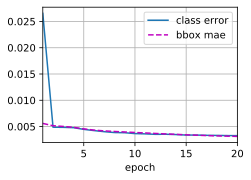

In [44]:
import d2l.torch as d2l
num_epochs, timer = 20, d2l.Timer()
animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])# defined in helper
net = net.to(device)
for epoch in range(num_epochs):
    # accuracy_sum, mae_sum, num_examples, num_labels
    metric = Accumulator(4) #defined in helper
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict the category and
        # offset (bbox layer) of each
        anchors, cls_preds, bbox_preds = net(X)
        # Label the category and offset of each anchor box
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled
        # category and offset values
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        
        # backpropogate the batch average loss
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

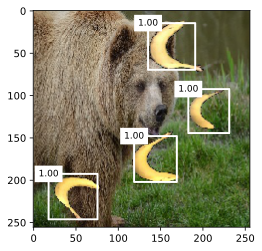

In [45]:
X = torchvision.io.read_image('banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1,2,0).long()

def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)


def display(img, output, threshold):
    fig = plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)